In [75]:
import time
from __future__ import division
from web3 import Web3, HTTPProvider
import json

import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("whitegrid")
seaborn.despine()
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

# Connect to the network
web3 = Web3(HTTPProvider('http://localhost:8545'))

# Get contract signature
with open('../ethereum/build/contracts/Market.json') as energy_file:    
    energy_json = json.load(energy_file)
contract_abi = energy_json['abi']
network_id = energy_json['networks'].keys()[-1]
contract_address = energy_json['networks'][network_id]['address']

# List accounts and set default account
accounts = web3.eth.accounts
web3.eth.defaultAccount = accounts[0]
contract = web3.eth.contract(contract_abi, contract_address)
energy_posted_event = contract.on('energy_posted_event', filter_params={'fromBlock': 'earliest'})
market_cleared_event = contract.on('market_cleared_event', filter_params={'fromBlock': 'earliest'})
bill_sent_event = contract.on('bill_sent_event', filter_params={'fromBlock': 'earliest'})
participant_at_clearing_request = contract.on('participant_at_clearing_request', filter_params={'fromBlock': 'earliest'})

In [76]:
# Check how many participants have been added
print('Number of accounts ' + str(len(accounts)))
print('Number of participants ' + str(contract.call().number_of_participant()))

Number of accounts 10
Number of participants 10


In [77]:
# Collect Blockchain info
market_15min_info = market_cleared_event.get(only_changes=False)
customers_15min_netload = energy_posted_event.get(only_changes=False)
customers_15min_bill = bill_sent_event.get(only_changes=False)
participants = participant_at_clearing_request.get(only_changes=False)

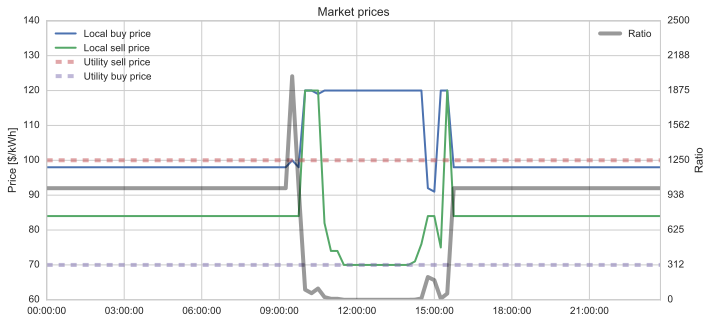

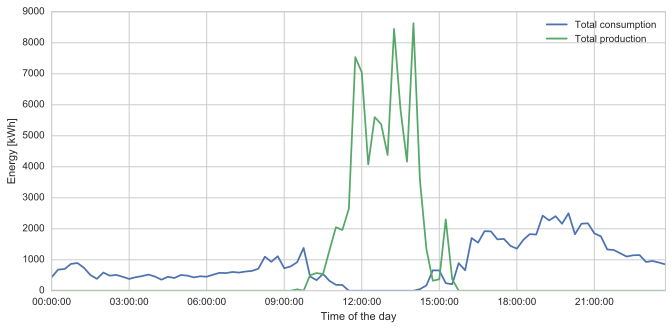

In [80]:
# Plot market prices
time = pandas.date_range('2017-09-21 00:00:00', periods=len(market_15min_info), freq='15T')
yb = [block['args']['_buy'] for block in market_15min_info]
ys = [block['args']['_sell'] for block in market_15min_info]
yr = [block['args']['_ratio'] for block in market_15min_info]

# Create plot
plt.figure(figsize=(11, 5), dpi=200)
plt.plot(time, yb, label='Local buy price', linewidth=2, alpha=1)
plt.plot(time, ys, label='Local sell price', linewidth=2, alpha=1)
plt.plot(time, [100] * len(time), '--', label='Utility sell price', linewidth=4, alpha=0.5)
plt.plot(time, [70] * len(time), '--',label='Utility buy price', linewidth=4, alpha=0.5)
plt.ylabel('Price [$/kWh]')
plt.ylim([60, 140])
plt.legend(loc=2)
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(time, yr, label='Ratio', linewidth=4, color='black', alpha=0.4)
ax2.set_yticks(np.linspace(ax2.get_yticks()[0],ax2.get_yticks()[-1],len(ax.get_yticks())))
ax2.grid(False)
plt.ylabel('Ratio')
plt.title('Market prices')
plt.xlabel('Time of the day')
plt.legend(loc=0)
plt.show()

# Plot market prices
# time = pandas.date_range('2017-09-21 00:00:00', periods=len(market_15min_info), freq='15T')
yc = [block['args']['_cons'] / 4 for block in market_15min_info]
yg = [block['args']['_gen'] / 4 for block in market_15min_info]

# Create plot
plt.figure(figsize=(11, 5), dpi=200)
plt.plot(time, yc, label='Total consumption')
plt.plot(time, yg, label='Total production')
plt.xlabel('Time of the day')
plt.ylabel('Energy [kWh]')
plt.legend(loc=0)
plt.show()

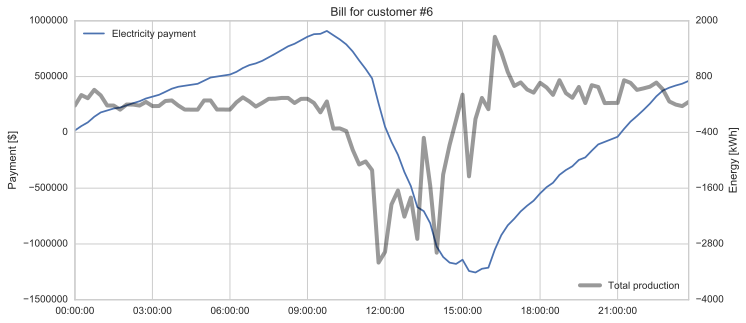

In [81]:
# Customer perspective
account_index = 6

customers_15min_bill2 = [block for block in customers_15min_bill 
                        if block['args']['_target'] == accounts[account_index]]
customers_15min_netload2 = [block for block in customers_15min_netload 
                           if block['args']['_target'] == accounts[account_index]]
time = pandas.date_range('2017-09-21 00:00:00', periods=len(market_15min_info), freq='15T')
bill = [block['args']['_value'] for block in customers_15min_bill2]
netload = [block['args']['_value'] for block in customers_15min_netload2]

# Create plot
plt.figure(figsize=(11, 5), dpi=200)
plt.plot(time, np.cumsum(bill), label='Electricity payment')
plt.ylabel('Payment [$]')
plt.legend(loc=2)
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(time, netload, label='Total production', linewidth=4, color='black', alpha=0.4)
ax2.set_yticks(np.linspace(ax2.get_yticks()[0],ax2.get_yticks()[-1],len(ax.get_yticks())))
ax2.grid(False)
plt.xlabel('Time of the day')
plt.ylabel('Energy [kWh]')
plt.legend(loc=4)
plt.title('Bill for customer #' + str(account_index))
plt.show()